In [1]:
from pathlib import Path
import pandas as pd 
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, Markdown
import ast

In [2]:
# Hardcoded paths -- modify as needed
data_dir = Path("/Volumes/Oxygen/aneurysm-detection-data")
train_path = data_dir / "train.csv"
train_localizers_path = data_dir / "train_localizers.csv"
series_dir = data_dir / "series"
segmentation_dir = data_dir / "segmentations" 

In [3]:
LABEL_COLS: list[str] = [
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
    'Aneurysm Present',
]
CAT_COLS = LABEL_COLS[:-1]  # all except 'Aneurysm Present'

In [4]:
for file in data_dir.iterdir():
    print(file)

/Volumes/T7 Shield/aneurysm-detection-data/rsna-intracranial-aneurysm-detection.zip
/Volumes/T7 Shield/aneurysm-detection-data/._rsna-intracranial-aneurysm-detection.zip
/Volumes/T7 Shield/aneurysm-detection-data/kaggle_evaluation
/Volumes/T7 Shield/aneurysm-detection-data/segmentations
/Volumes/T7 Shield/aneurysm-detection-data/series
/Volumes/T7 Shield/aneurysm-detection-data/train.csv
/Volumes/T7 Shield/aneurysm-detection-data/train_localizers.csv


## 📂 High-Level Data Folder Exploration

In [5]:
# High level data exploration

# Series Folders
## All series_paths are unique and of length 64
series_list = [series_path.name for series_path in list(series_dir.iterdir())]
series_count  = len(series_list)
char_counts = set([len(series) for series in series_list])
assert series_count == len(set(series_list))
print(
    "\n[Series folders]"
    f"\n• Total unique series : {series_count:,}"
    f"\n• Each series ID length: {sorted(char_counts)}"
)

# Segmentation Folders
## TO LOOK INTO: For every series segmentation, we have a .nii file and a _cowseg.nii file.
seg_list = [seg_path.name for seg_path in list(segmentation_dir.iterdir())]
char_counts = Counter([len(seg) for seg in seg_list])
unique_segs = set([seg_path.replace("_cowseg", "").replace(".nii", "") for seg_path in seg_list])
print(
    "\n[Segmentation folders]"
    f"\n• Pixel-wise segmentations: {len(unique_segs):,}"
    f"\n• Name length distribution : {dict(char_counts)}"
)

# Intersection between series and segmentation folders data
intersection_set = unique_segs & set(series_list)
missing_series = unique_segs - set(series_list)
print(
    "\n[Cross-check]"
    f"\n• Series with both segmentation & series data: {len(intersection_set):,}"
    f"\n• Segmentation-only series (count): {len(missing_series):,}"
    f"\n• IDs missing from series data:\n   {', '.join(sorted(missing_series)) if missing_series else 'None'}"
)


[Series folders]
• Total unique series : 4,348
• Each series ID length: [64]

[Segmentation folders]
• Pixel-wise segmentations: 178
• Name length distribution : {68: 178, 75: 178}

[Cross-check]
• Series with both segmentation & series data: 177
• Segmentation-only series (count): 1
• IDs missing from series data:
   1.2.826.0.1.3680043.8.498.43502795339700498960289295234851562632


## 🏷️ Class & Metadata Analysis (train.csv)

In [6]:
df_train = pd.read_csv(train_path)
df_train.head()

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,64,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10005158603912009425...,58,Male,CTA,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1.2.826.0.1.3680043.8.498.10009383108068795488...,71,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10012790035410518400...,48,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
def df_train_quickcheck(df_train, series_list, label_cols, id_col="SeriesInstanceUID"):
    # --- Core checks ---
    n_rows = len(df_train)
    n_unique = df_train[id_col].nunique()
    all_unique = (n_unique == n_rows)

    # Nulls summary per column
    df_null = (
        df_train.isna().agg(['sum', 'mean']).T
        .rename(columns={'sum': 'null_count', 'mean': 'null_pct'})
        .assign(null_pct=lambda x: (x['null_pct'] * 100).round(2))
    )
    total_nulls = int(df_null['null_count'].sum())
    max_null_pct = df_null['null_pct'].max() if not df_null.empty else 0.0

    # Filesystem ↔ train.csv intersection
    train_ids = set(df_train[id_col].astype(str))
    series_set = set(map(str, series_list))
    intersection = train_ids & series_set
    missing_in_fs = sorted(train_ids - series_set)

    # Label sanity (binary)
    # If there are NaNs in label columns, drop them before binary check
    labels_binary = df_train[label_cols].stack().dropna().isin([0, 1]).all()

    # --- summary output ---
    md = f"""
### ✅ Dataset Quick Check
- **Rows**: **{n_rows:,}**
- **Unique `{id_col}`**: **{n_unique:,}** {'✅' if all_unique else '⚠️ not all unique'}
- **Nulls**: **{'none' if total_nulls == 0 else f'{total_nulls:,} total; max {max_null_pct:.1f}% in a column'}** {'✅' if total_nulls == 0 else '⚠️'}
- **Train IDs with folders**: **{len(intersection):,}/{n_unique:,}** {'✅' if len(missing_in_fs) == 0 else f'⚠️ {len(missing_in_fs)} missing'}
- **Labels binary (0/1)**: **{'Yes' if labels_binary else 'No'}** {'✅' if labels_binary else '⚠️'}
"""
    display(Markdown(md))

    return {
        "df_null": df_null,                 # per-column nulls (counts & %)
        "missing_series_ids": missing_in_fs,# list of train IDs missing in folders
        "intersection_count": len(intersection),
        "all_unique_ids": all_unique,
        "labels_binary": labels_binary
    }

# --- Usage ---
artifacts = df_train_quickcheck(df_train, series_list, LABEL_COLS)
# If needed later:
# artifacts["df_null"]
# artifacts["missing_series_ids"]


### ✅ Dataset Quick Check
- **Rows**: **4,348**
- **Unique `SeriesInstanceUID`**: **4,348** ✅
- **Nulls**: **none** ✅
- **Train IDs with folders**: **4,348/4,348** ✅
- **Labels binary (0/1)**: **Yes** ✅


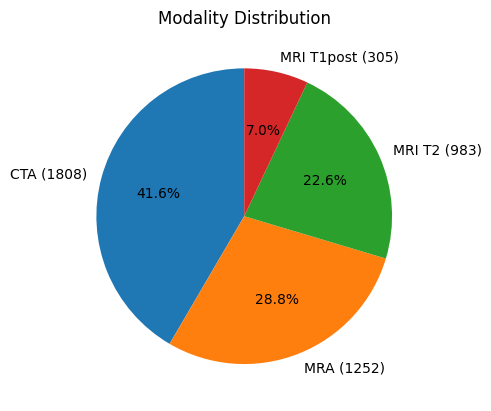

In [8]:
counts = df_train['Modality'].value_counts()
counts.plot.pie(
    labels=[f'{idx} ({val})' for idx, val in counts.items()],
    autopct='%.1f%%',
    startangle=90,
    ylabel=''
)
plt.title('Modality Distribution')
plt.show()

In [9]:
# Boolean mask: aneurysm present but no location columns are 1
bad_rows = df_train[(df_train['Aneurysm Present'] == 1) & (df_train[CAT_COLS].sum(axis=1) == 0)]
# Boolean mask: at least one location is 1, but 'Aneurysm Present' is 0
bad_rows_reverse = df_train[
    (df_train[CAT_COLS].sum(axis=1) > 0) & (df_train['Aneurysm Present'] == 0)
]

# Print results
if bad_rows.empty:
    print("✅ All 'Aneurysm Present' rows also have at least one location marked.")
else:
    print(f"❌ Found {len(bad_rows)} rows with 'Aneurysm Present' but no specific location marked.")
    display(bad_rows)  # optional: show the offending rows
    
if bad_rows_reverse.empty:
    print("✅ All rows with a specific artery marked also have 'Aneurysm Present' = 1.")
else:
    print(f"❌ Found {len(bad_rows_reverse)} rows with a location marked but no 'Aneurysm Present'.")
    display(bad_rows_reverse)  # optional: show offending rows
    

✅ All 'Aneurysm Present' rows also have at least one location marked.
✅ All rows with a specific artery marked also have 'Aneurysm Present' = 1.


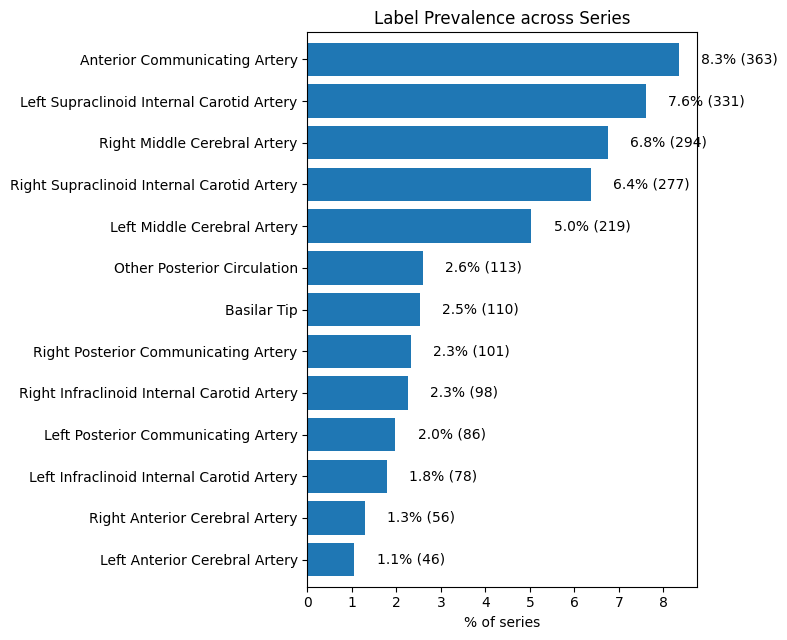

In [10]:
# Here we're only going to look at CAT_COLS, because we checked above that 'Aneurysm Present' is consistent
df_labels = (
    pd.DataFrame({
        'count': df_train[CAT_COLS].sum(),
        'prevalence_pct': df_train[CAT_COLS].mean().mul(100)
    })
    .sort_values('prevalence_pct', ascending=True)
)

ax = df_labels['prevalence_pct'].plot.barh(figsize=(8, 0.5*len(df_labels)), width=0.8)
ax.set_xlabel('% of series')
ax.set_ylabel('')
ax.set_title('Label Prevalence across Series')

# annotate each bar with "xx.x% (count)"
for i, (pct, cnt) in enumerate(zip(df_labels['prevalence_pct'], df_labels['count'])):
    ax.text(pct + 0.5, i, f'{pct:.1f}% ({cnt:,})', va='center')

plt.tight_layout()
plt.show()

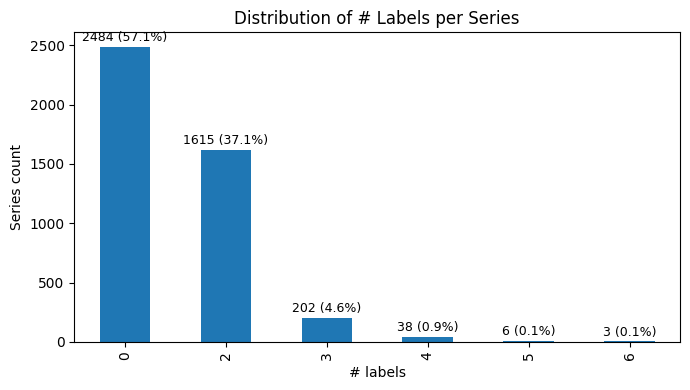

In [11]:
counts = df_train[LABEL_COLS].sum(axis=1).value_counts().sort_index()
percentages = counts / len(df_train) * 100

ax = counts.plot.bar(figsize=(7,4))
ax.set_title('Distribution of # Labels per Series')
ax.set_xlabel('# labels')
ax.set_ylabel('Series count')

# Add text annotations (count + percentage) above each bar
for i, (count, pct) in enumerate(zip(counts, percentages)):
    ax.text(i, count + (0.01 * counts.max()),   # small offset above bar
            f'{count} ({pct:.1f}%)',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

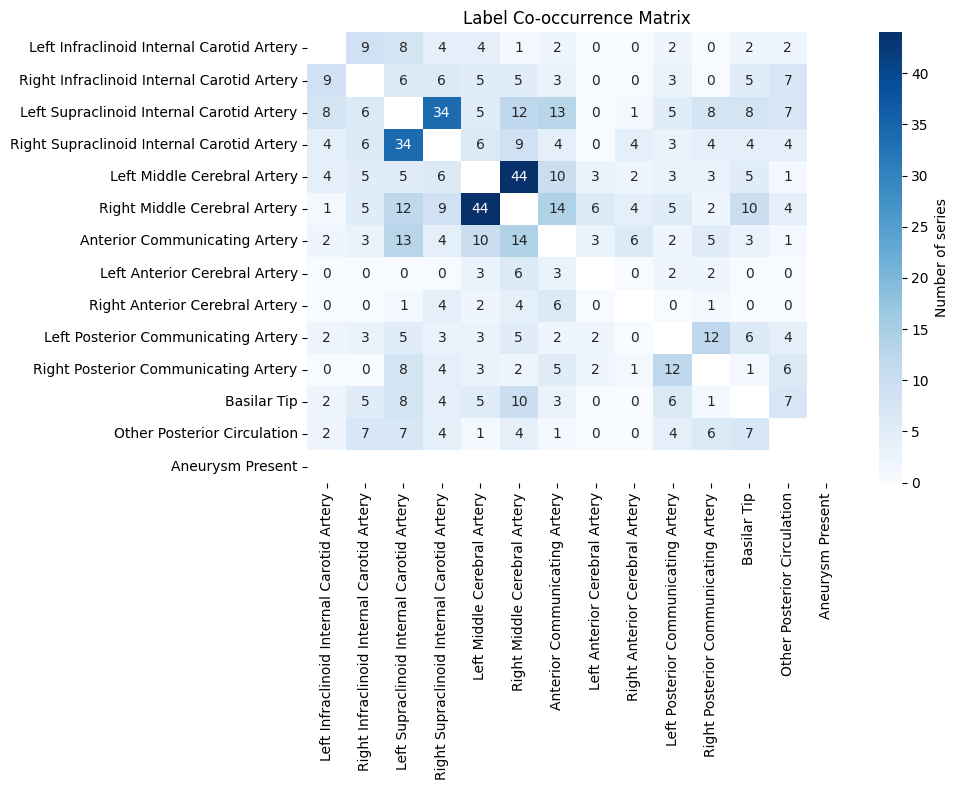

In [12]:
co_counts = df_train[LABEL_COLS].T @ df_train[LABEL_COLS]
co_pct = co_counts / len(df_train) * 100
mask = np.eye(len(co_counts), dtype=bool)

# Comment this section to unmask the aneurysm label
aneurysm_idx = LABEL_COLS.index("Aneurysm Present")
mask[aneurysm_idx, :] = True
mask[:, aneurysm_idx] = True

plt.figure(figsize=(10,8))
sns.heatmap(
    co_counts,           # use co_pct for percentages
    annot=True, fmt='d', # or fmt='.1f' with co_pct
    mask=mask,
    cmap='Blues',
    cbar_kws={'label': 'Number of series'}  # or '% of series'
)
plt.title('Label Co-occurrence Matrix')
plt.tight_layout()
plt.show()

## 🎯 Bounding Box Analysis (train_localizers.csv)

In [13]:
df_train_loc = pd.read_csv(train_localizers_path)
df_train_loc.head()

,SeriesInstanceUID,SOPInstanceUID,coordinates,location
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,"{'x': 194.87253141831238, 'y': 178.32675044883...",Right Middle Cerebral Artery
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,"{'x': 189.23979878597123, 'y': 209.19184886465...",Right Middle Cerebral Artery
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,"{'x': 208.2805049088359, 'y': 229.78962131837307}",Right Infraclinoid Internal Carotid Artery
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,"{'x': 249.86745590416498, 'y': 220.623044646393}",Anterior Communicating Artery


In [14]:
n_rows_loc = len(df_train_loc)
n_series_loc = df_train_loc['SeriesInstanceUID'].nunique()
pct_of_train = n_series_loc / len(df_train) * 100

print(
    "\n[Bounding boxes]"
    f"\n• Total bounding boxes : {n_rows_loc:,}"
    f"\n• Series represented   : {n_series_loc:,}"
    f"\n• Share of dataset     : {pct_of_train:.2f}%"
)


[Bounding boxes]
• Total bounding boxes : 2,251
• Series represented   : 1,862
• Share of dataset     : 42.82%


In [15]:
series_bbox = set(df_train_loc['SeriesInstanceUID'].unique())
seg_no_bbox = unique_segs - series_bbox
bbox_no_seg = series_bbox - unique_segs
intersection_seg_bbox = unique_segs & series_bbox
print(
    "\n[Segmentation vs Bounding Boxes]"
    f"\n• Series with segmentation but no bounding box: {len(seg_no_bbox):,}"
    f"\n• Series with bounding box but no segmentation: {len(bbox_no_seg):,}"
    f"\n• Series with both segmentation & bounding box: {len(intersection_seg_bbox):,}"
)


[Segmentation vs Bounding Boxes]
• Series with segmentation but no bounding box: 35
• Series with bounding box but no segmentation: 1,719
• Series with both segmentation & bounding box: 143


In [16]:
df_null = (
    df_train_loc.isna().agg(['sum', 'mean']).T
    .rename(columns={'sum': 'null_count', 'mean': 'null_pct'})
    .assign(null_pct=lambda x: (x['null_pct'] * 100).round(2))
)
total_nulls = int(df_null['null_count'].sum())
max_null_pct = df_null['null_pct'].max() if not df_null.empty else 0.0
print(
    "\n[train_localizers.csv Null Summary]"
    f"\n• Total null values: {total_nulls:,}"
    f"\n• Max null % in a column: {max_null_pct:.1f}%"
)


[train_localizers.csv Null Summary]
• Total null values: 0
• Max null % in a column: 0.0%


In [17]:
# Location label cross-check
locations = set(df_train_loc['location'].unique())
extra_labels = locations - set(LABEL_COLS)

print(
    "\n[Location label cross-check]"
    f"\n• Total unique locations : {len(locations):,}"
    f"\n• Extra labels vs LABEL_COLS: "
    f"{', '.join(sorted(extra_labels)) if extra_labels else 'None'}"
)


[Location label cross-check]
• Total unique locations : 13
• Extra labels vs LABEL_COLS: None


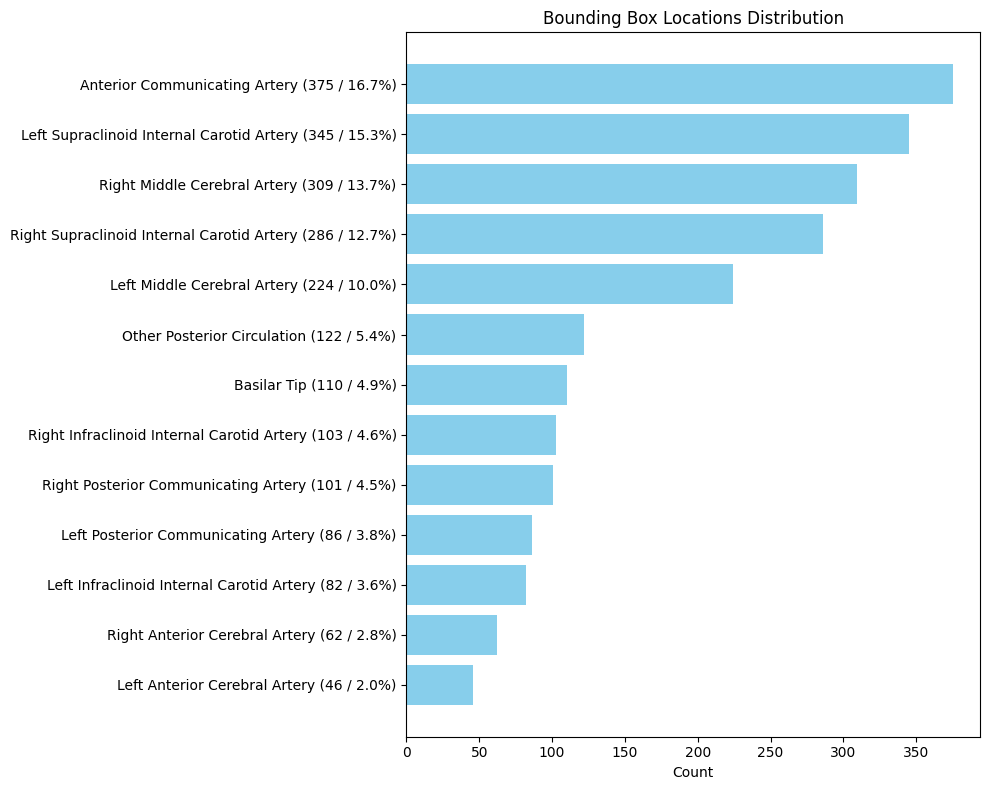

In [18]:
counts = Counter(df_train_loc['location'])   # your data
total = sum(counts.values())

# Sort by descending count for clarity
sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)
labels = [f"{k} ({v} / {v/total:.1%})" for k, v in sorted_items]
sizes  = [v for _, v in sorted_items]

plt.figure(figsize=(10,8))
plt.barh(range(len(sizes)), sizes, color='skyblue')
plt.yticks(range(len(sizes)), labels)
plt.gca().invert_yaxis()           # highest count on top
plt.xlabel('Count')
plt.title("Bounding Box Locations Distribution")
plt.tight_layout()
plt.show()


In [19]:
def check_bbox_vs_labels(
    df_train: pd.DataFrame,
    df_train_loc: pd.DataFrame,
    uid_col: str = "SeriesInstanceUID",
    location_col: str = "location",
    label_cols: list | None = None,
):
    """
    Compare per-series bbox 'location' labels in df_train_loc to multi-hot columns in df_train.

    Args:
        df_train: one row per series; columns are uid_col + multi-hot label columns (0/1).
        df_train_loc: many rows per series; columns include uid_col and location_col (string label).
        uid_col: name of the uid column present in both dataframes.
        location_col: name of the bbox label column in df_train_loc.
        label_cols: explicit list of multi-hot label columns in df_train (optional).
                    If None, uses all columns except uid_col.

    Returns:
        results_df: one row per series present in df_train_loc with:
            - expected_labels: set of labels from df_train (multi-hot=1)
            - observed_labels: set of labels mapped from df_train_loc locations
            - missing_labels: expected - observed
            - extra_labels: observed - expected
            - ok: True if sets match exactly and no unmapped
        summary: dict with quick counts
    """
    
    df_train_exp = df_train[[uid_col] + label_cols].copy()

    # Can't have a bounding box for aneurism present.
    expected_by_uid = {
        row[uid_col]: set([c for c in label_cols if row[c] == 1 if c != "Aneurysm Present"])
        for _, row in df_train_exp.iterrows()
    }

    # Observed bbox locations per series from df_train_loc
    observed_by_uid = (
        df_train_loc[[uid_col, location_col]]
        .dropna(subset=[location_col])
        .groupby(uid_col)[location_col]
        .apply(lambda s: set(s.astype(str)))
        .to_dict()
    )

    # Compare for every series present in df_train_loc
    rows = []
    for uid in df_train_loc[uid_col].unique():
        expected = expected_by_uid.get(uid, set())
        observed = observed_by_uid.get(uid, set())
        missing = sorted(expected - observed)
        extra = sorted(observed - expected)
        ok = (len(missing) == 0) and (len(extra) == 0)

        rows.append({
            uid_col: uid,
            "expected_labels": sorted(expected),
            "observed_labels": sorted(observed),
            "missing_labels": missing,
            "extra_labels": extra,
            "ok": ok,
        })
        
    results_df = pd.DataFrame(rows).sort_values([ "ok", uid_col ], ascending=[True, True])

    summary = {
        "num_series_in_loc": len(observed_by_uid),
        "num_ok": int(results_df["ok"].sum()),
        "num_mismatched": int((~results_df["ok"]).sum()),
    }

    return results_df, summary

results_df, summary = check_bbox_vs_labels(
    df_train,
    df_train_loc,
    location_col = "location",
    label_cols = LABEL_COLS,
)

print(
    "\n[Bounding boxes vs multi-hot labels]"
    f"\n• Series checked : {summary['num_series_in_loc']:,}"
    f"\n• Perfect matches: {summary['num_ok']:,}"
    f"\n• Mismatches     : {summary['num_mismatched']:,}"
)
# Great! All bounding box locations match the multi-hot labels exactly, not counting the "Aneurism Present" label.


[Bounding boxes vs multi-hot labels]
• Series checked : 1,862
• Perfect matches: 1,862
• Mismatches     : 0


## 👁️ Visualize bounding box positions 2D

In [20]:
# interpret str dict in coordinates column and x & y values
df_train_loc[['x', 'y']] = df_train_loc['coordinates'].apply(
    lambda s: pd.Series(ast.literal_eval(s))[['x', 'y']]
)
df_train_loc = df_train_loc.merge(
    df_train[['SeriesInstanceUID', 'Modality']],
    on='SeriesInstanceUID',
    how='left',           # keep every bbox even if modality is missing
    validate='many_to_one'  # each SeriesInstanceUID maps to exactly one Modality
)
df_train_loc.head()

,SeriesInstanceUID,SOPInstanceUID,coordinates,location,x,y,Modality
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation,258.362119,261.359900,CTA
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,"{'x': 194.87253141831238, 'y': 178.32675044883...",Right Middle Cerebral Artery,194.872531,178.326750,CTA
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,"{'x': 189.23979878597123, 'y': 209.19184886465...",Right Middle Cerebral Artery,189.239799,209.191849,MRA
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,"{'x': 208.2805049088359, 'y': 229.78962131837307}",Right Infraclinoid Internal Carotid Artery,208.280505,229.789621,CTA
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,"{'x': 249.86745590416498, 'y': 220.623044646393}",Anterior Communicating Artery,249.867456,220.623045,CTA


In [21]:
# function to plot bbox centers by modality
def plot_loc_by_mod(df: pd.DataFrame, modality: str, color_of: dict[str, tuple]):
    fig, ax = plt.subplots(figsize=(8, 8))
    g = df[df['Modality'] == modality]
    for lab, gg in g.groupby('location'):
        ax.scatter(gg['x'], gg['y'], s=5, alpha=0.85, c=[color_of[lab]], label=lab)

    ax.set_title(f"{modality} : BBox Centers Colored by Label")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
    plt.tight_layout()
    plt.show()

## Modality: CTA

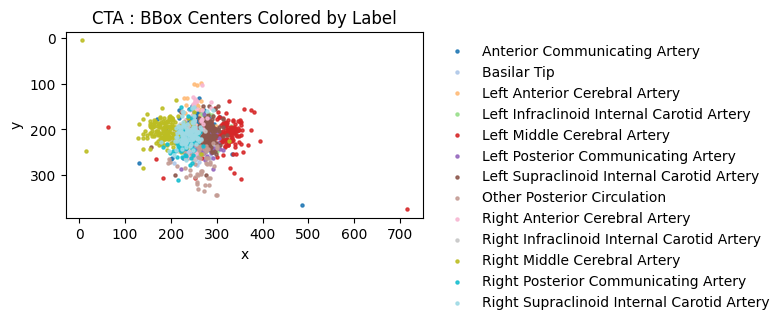

## Modality: MRA

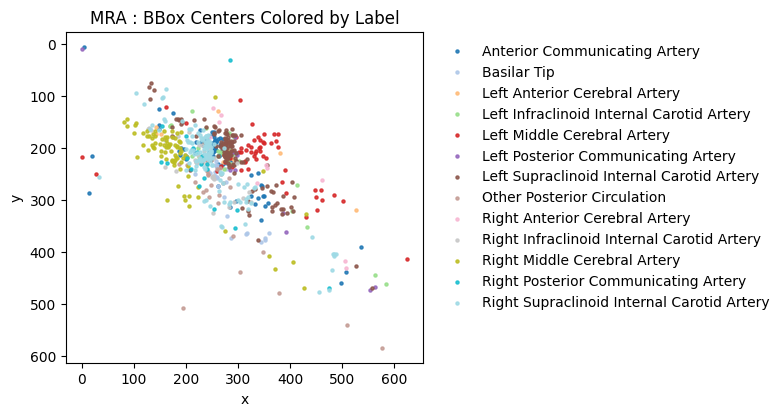

## Modality: MRI T1post

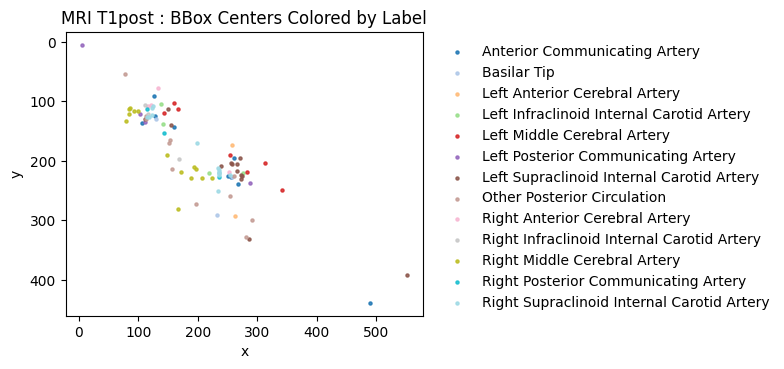

## Modality: MRI T2

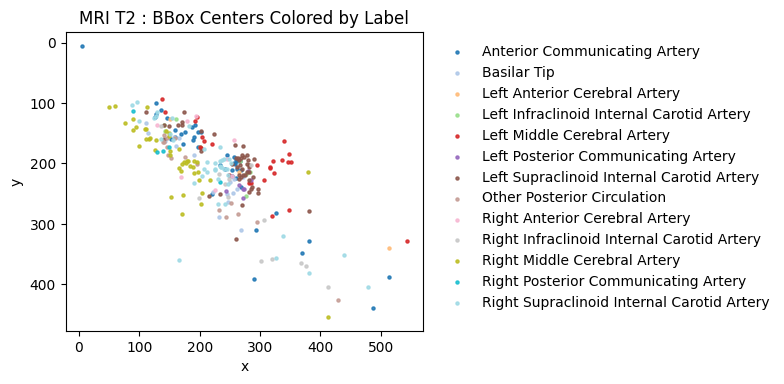

In [22]:
# Color map per label, consistent across plots
labels = sorted(df_train_loc['location'].unique())
cmap = plt.get_cmap('tab20', len(labels))
color_of = {lab: cmap(i) for i, lab in enumerate(labels)}

for mod in df_train_loc["Modality"].dropna().unique():
    display(Markdown(f"## Modality: {mod}"))
    plot_loc_by_mod(df_train_loc, mod, color_of)


## visualize locations 3D

In [23]:
df_loc_world = pd.read_csv("data/filtered_localizers_world.csv")
df_loc_world.head()

,SeriesInstanceUID,SOPInstanceUID,coordinates,location,world_x,world_y,world_z
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation,1.257767,-164.924850,-97.000000
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,"{'x': 194.87253141831238, 'y': 178.32675044883...",Right Middle Cerebral Artery,-14.945473,-202.072052,181.000000
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,"{'x': 189.23979878597123, 'y': 209.19184886465...",Right Middle Cerebral Artery,-27.459164,-46.386383,55.808483
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,"{'x': 208.2805049088359, 'y': 229.78962131837307}",Right Infraclinoid Internal Carotid Artery,-26.076218,-209.342255,-647.900024
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,"{'x': 249.86745590416498, 'y': 220.623044646393}",Anterior Communicating Artery,-2.591866,-38.262810,-143.000000


/var/folders/sz/4qxfkyhj18ddrkff4h014m2r0000gn/T/ipykernel_97203/4001355726.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(CAT_COLS))


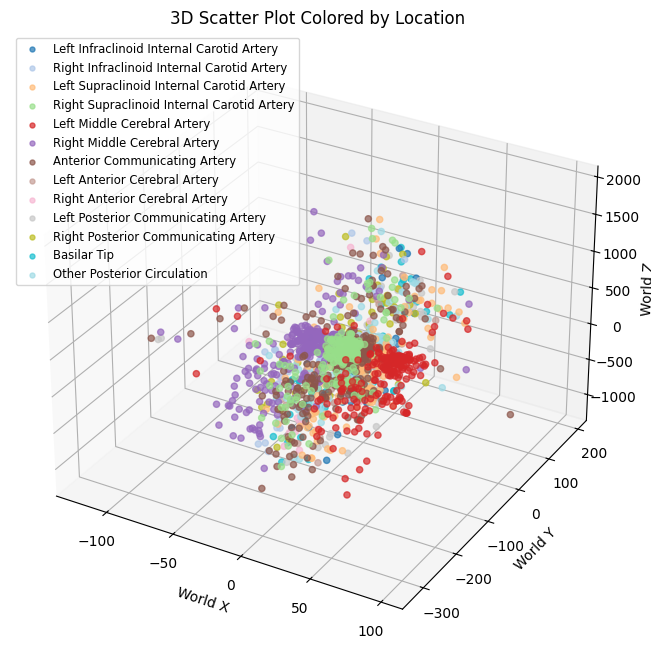

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # enables 3D plotting

# Create a color map based on unique categories in 'location'
colors = plt.cm.get_cmap('tab20', len(CAT_COLS))

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, category in enumerate(CAT_COLS):
    subset = df_loc_world[df_loc_world['location'] == category]
    ax.scatter(subset['world_x'], subset['world_y'], subset['world_z'],
               color=colors(i), label=category, s=20, alpha=0.7)

ax.set_xlabel('World X')
ax.set_ylabel('World Y')
ax.set_zlabel('World Z')
ax.set_title('3D Scatter Plot Colored by Location')
ax.legend(loc='best', fontsize='small', markerscale=0.8)

plt.show()
